In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import CompressedFisher

In [7]:

nKs = 100
ks = 10**np.linspace(-4,0,nKs)



In [13]:

def pk_theory(ks,params):
    a,ns,alpha= params
    return a+ns*ks+alpha*ks**.5

def generateSims(params,nSims=1,params_covMat= np.array([1,1,1.])):
    pk_mu = pk_theory(ks,params)
    pk_mu_true = pk_theory(ks,params_covMat)
    if nSims==1:
        return  pk_mu+np.random.randn(nKs)*np.sqrt(2)*pk_mu_true*.1#noiseRatio
    else:
        return  pk_mu+np.random.randn(nSims,nKs)*np.sqrt(2)*pk_mu_true*.1#noiseRatio

def generateCovMat(params):
    pk_mu = pk_theory(ks,params)*.1
    return np.diag(2*pk_mu**2)

def theoretical_derivs(params):
    pk_mu = pk_theory(ks,params)
    nParams = len(params)
    derivs_thry = np.zeros([nParams,nKs])
    derivs_thry[0] = np.ones(nKs)
    derivs_thry[1] = ks.copy()
    derivs_thry[2] = np.sqrt(ks)
    return derivs_thry


def generate_deriv_sims(paramter_names,params,deltaParams,nSims):
    deriv_sims = {}
    for i,name in enumerate(paramter_names):
        derivs_ens = np.zeros([2,nSims,nKs])
        params_plus = np.array(params)
        params_plus[i]+=deltaParams[i]
        
        params_minus = np.array(params)
        params_minus[i]-=deltaParams[i]
          
        derivs_ens[0] = generateSims(params_minus,nSims)
        derivs_ens[1] = generateSims(params_plus,nSims)
        deriv_sims[name] = derivs_ens
    return deriv_sims


In [14]:

def fisherTheory(params):
    derivs = theoretical_derivs(params)
    covMat = generateCovMat(params)
    nParams = len(params)
    fisher = np.zeros([nParams,nParams])
    for i in range(nParams):
        for j in range(i+1):
            fisher[i,j] = fisher[j,i] = np.dot(derivs[i], np.linalg.solve(covMat,derivs[j]))
    return fisher

In [15]:
params_fid = np.array([1,1,1.])
delta_params = np.array([.1,.1,.1,])
parameter_names = [r"$\alpha$", r"$\beta$", r"$\gamma$"]
dict_param_steps = {parameter_names[i]:delta_params[i] for i in range(len(params_fid))}

In [87]:
nSimsCovMat = 20000
nSims_deriv = 2000

In [88]:

fisher_true = fisherTheory(params_fid)
print(fisher_true)

[[3508.3941183   144.39626774  425.60542035]
 [ 144.39626774   51.69879884   77.75371946]
 [ 425.60542035   77.75371946  144.39626774]]


In [89]:
compress_frac_split = 0.5

In [90]:
covmat_sims = generateSims(params_fid,nSimsCovMat)
dict_deriv_sims = generate_deriv_sims(parameter_names,params_fid,delta_params,nSims=nSims_deriv)


In [91]:
cFisher = CompressedFisher.gaussianFisher(parameter_names,nSims_deriv,include_deriv_covmat=False,deriv_spline_order=2)


In [92]:
cFisher.initailize_covmat(covmat_sims)
cFisher.initailize_mean(covmat_sims)
cFisher.initailize_deriv_sims(dic_deriv_sims=dict_deriv_sims,dict_param_steps=dict_param_steps)


In [93]:
cFisher.generate_deriv_sim_splits(compress_frac_split)

  

In [94]:
  
stnd_constraint    = cFisher.compute_fisher_forecast(parameter_names)
stnd_constraint_bias = cFisher.est_fisher_forecast_bias(parameter_names)


compressed_constraint = cFisher.compute_compressed_fisher_forecast(parameter_names)
compressed_constraint_bias = cFisher.est_compressed_fisher_forecast_bias(parameter_names)


combined_constraint = cFisher.compute_combined_fisher_forecast(parameter_names)
  

In [102]:
print(np.diag(stnd_constraint)**.5,np.diag(stnd_constraint_bias/stnd_constraint))
print(np.diag(compressed_constraint)**.5,np.diag(compressed_constraint_bias/compressed_constraint))
print(np.diag(combined_constraint)**.5)
print(np.diag(np.linalg.inv(fisher_true))**.5)


[0.02235821 0.26375463 0.18288554] [0.12262336 0.46792443 0.41558621]
[0.03184526 0.59871795 0.39407093] [0.04810779 0.07755877 0.07534678]
[0.0256452  0.39655288 0.26552069]
[0.02562638 0.38803585 0.27252169]


In [96]:
      
std_nsim, std_mns,std_stds = cFisher.run_fisher_deriv_stablity_test(parameter_names,)

comp_nsim, comp_mns,comp_stds = cFisher.run_compressed_fisher_deriv_stablity_test(parameter_names,compress_frac_split)
geom_nsim, geom_mns,geom_stds = cFisher.run_combined_fisher_deriv_stablity_test(parameter_names,compress_frac_split)


200.0 
 [0.02016542 0.15964997 0.11932597] 
 [0.00283507 0.02605256 0.02414378]
400.0 
 [0.0213989  0.20568636 0.15031325] 
 [0.00418403 0.04042443 0.02837033]
666.6666666666666 
 [0.02254289 0.24563678 0.1708199 ] 
 [0.00554108 0.06725268 0.04639763]
800.0 
 [0.02150947 0.24824653 0.1752565 ] 
 [0.00453118 0.03361067 0.02060246]
1000.0 
 [0.02237175 0.27392733 0.1915676 ] 
 [0.00167914 0.01770228 0.0379109 ]
2000.0 
 [0.02307296 0.30585224 0.21149553] 
 [0. 0. 0.]
200.0 
 [0.07826075 1.95116375 1.39997135] 
 [ 0.74944222 20.49853152 14.97849046]
400.0 
 [0.03571436 0.54353209 0.39543221] 
 [0.12544574 3.02698561 1.74973314]
666.6666666666666 
 [0.03130971 0.73694361 0.56563861] 
 [0.02376279 0.4082278  0.26025515]
800.0 
 [0.03240551 0.6614569  0.42828215] 
 [0.01437724 0.46769513 0.29037983]
1000.0 
 [0.02981591 0.62616282 0.40326311] 
 [0.01480822 0.31706721 0.16224313]
2000.0 
 [0.02769696 0.52912326 0.34285992] 
 [0. 0. 0.]
200.0 
 [0.02516024 0.37135792 0.2459108 ] 
 [0.03033672 

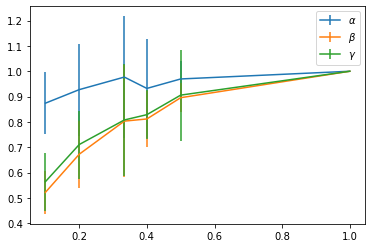

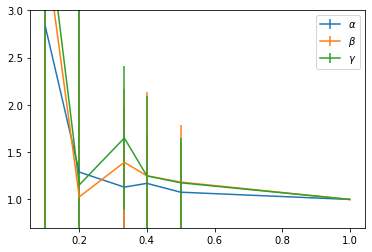

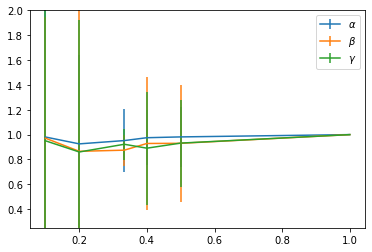

In [97]:

for i,p in enumerate(parameter_names):
    plt.errorbar(std_nsim/std_nsim[-1],std_mns[:,i,i]**.5/std_mns[-1,i,i]**.5,yerr=std_stds[:,i,i]**.5/std_mns[-1,i,i]**.5,label=parameter_names[i])
#plt.plot(geom_nsim/geom_nsim[-1],(geom_nsim/geom_nsim[-1])**.5,scaley=False,color='k',alpha=.5,linestyle=':')

plt.legend()
plt.show()

for i,p in enumerate(parameter_names):
    plt.errorbar(comp_nsim/comp_nsim[-1],comp_mns[:,i,i]**.5/comp_mns[-1,i,i]**.5,yerr=comp_stds[:,i,i]**.5/comp_mns[-1,i,i]**.5,label=parameter_names[i])
#plt.plot(geom_nsim/geom_nsim[-1],(geom_nsim/geom_nsim[-1])**.5,scaley=False,color='k',alpha=.5,linestyle=':')

plt.legend()
plt.ylim([.7,3])
plt.show()

for i,p in enumerate(parameter_names):
    plt.errorbar(geom_nsim/geom_nsim[-1],geom_mns[:,i,i]**.5/geom_mns[-1,i,i]**.5,yerr=geom_stds[:,i,i]**.5/geom_mns[-1,i,i]**.5,label=parameter_names[i])
#plt.plot(geom_nsim/geom_nsim[-1],(geom_nsim/geom_nsim[-1])**.5,scaley=False,color='k',alpha=.5,linestyle=':')
plt.legend()
plt.ylim([.25,2])
plt.show()
#plt.yscale('log')
#plt.yscale('log')

In [98]:

stnd_fisher     = cFisher._compute_fisher_matrix(parameter_names)
stnd_fisher_err     = cFisher._compute_fisher_matrix_error(parameter_names)


compressed_fisher  = cFisher._compute_compressed_fisher_matrix(parameter_names)
compressed_fisher_err  = cFisher._compute_compressed_fisher_matrix_error(parameter_names)


combined_fisher = cFisher._compute_combined_fisher_matrix(parameter_names)